In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('/home/jb07/nipype_installation/')
sys.path.append('/home/jb07/python_modules/')

from IPython.display import display
from ipywidgets import FloatProgress

In [4]:
import os
import numpy as np
import pandas as pd
import re
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split

In [5]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
rcParams['figure.autolayout'] = True
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches

In [6]:
def get_imaging_ID(ID_string, ID_table):
    """
    Function to match behavioural and imaging IDs
    """
    
    # Reading data from the lookup table
    import pandas as pd
    data = pd.Series.from_csv(ID_table)

    # Removing brackts
    import re
    for counter in range(1,len(data)):
        entry = data[counter]
        if re.search(r"[(){}[\]]+",str(entry)):
            data[counter] = entry[1:-1]

    # Getting the matching ID
    try:
        ID = data[data.index == ID_string].values.tolist()
        return ID[0]
    except:
        return float('nan')

In [7]:
def get_connectivity_matrix(track_file, ROI_file):
    """
    This function creates a connectivity matrix from a given track and parcellation file
    
    Inputs
    track_file: a TrackVis format file with streamlines
    ROI_file: a parcellation volume in the same space as the streamlines
    
    Output
    matrix: matrix of streamline counts going from each ROI to each other ROI
    size_matrix: matrix of ROI volumes
    length_matrix: matrix of strealime length from each ROI to each other ROI
    """
    
    import nibabel as nib
    import numpy as np
    from dipy.tracking import utils

    # Identity matrix affine
    affine = np.eye(4)

    # Loading the ROI file
    img = nib.load(ROI_file)
    labels = nib.Nifti1Image(img.get_data(), affine).get_data()

    # Loading the streamlines
    streams, hdr = nib.trackvis.read(track_file)
    streamlines = [s[0] for s in streams]
    affine = nib.trackvis.aff_from_hdr(hdr, atleast_v2=True)

    # Only keeping streamlines that pass through the ROIs
    ROI_mask = labels > 0
    target_streamlines = utils.target(streamlines, ROI_mask, affine=affine)

    # Constructing the streamlines matrix
    matrix, mapping = utils.connectivity_matrix(
        streamlines=target_streamlines, label_volume=labels.astype('int'), affine=affine, symmetric=True, return_mapping=True, mapping_as_streamlines=True)

    # Removing the background label
    matrix = matrix[1:, :]
    matrix = matrix[:, 1:]

    # Density matrix normalized by ROI size
    ROI_sizes = [np.sum(labels[labels == ROI]) for ROI in np.unique(labels)[1:]]
    size_matrix = np.zeros(shape=np.repeat(len(np.unique(labels)[1:]),2))

    for ROI1 in range(0,len(np.unique(labels)[1:])):
        for ROI2 in range(0,len(np.unique(labels)[1:])):
            size_matrix[ROI1, ROI2] = ROI_sizes[ROI1] + ROI_sizes[ROI2]

    # Density matrix normalized by streamline length
    length_matrix = np.zeros(shape=np.repeat(len(np.unique(labels)[1:]),2))

    for ROI1 in range(0,len(np.unique(labels)[1:])):
        for ROI2 in range(0,len(np.unique(labels)[1:])):
            length_matrix[ROI1, ROI2] = np.median(list(utils.length(mapping[ROI1, ROI2])))

    length_matrix[np.tril_indices(n=len(length_matrix))] = 0
    length_matrix = length_matrix.T + length_matrix - np.diagonal(length_matrix)

    return matrix, size_matrix, length_matrix

Creating connectivity matrices for each participant

In [8]:
def load_matrices(subject_list, tract):
    w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
    display(w)

    counter = 0
    matrices = []

    for subject in subject_list:
        track_file = '/imaging/jb07/CALM/BrainTypes/CALM/tractography/' + subject + '/' + tract + '.trk'
        ROI_file = '/imaging/jb07/CALM/BrainTypes/CALM/whole_brain_tractography/_subject_id_' + subject + '/applyreg/aparc_renum_expanded_warped.nii.gz'
        matrix, size_matrix, length_matrix = get_connectivity_matrix(track_file, ROI_file)

        # Exclude label entries 
        entries_to_exclude = [ 0,  1,  2,  3,  9, 10, 14, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
        matrix = np.delete(matrix,entries_to_exclude, axis=0)
        matrix = np.delete(matrix,entries_to_exclude, axis=1)
        
        # Removing inter-hemispheric entries
        labels = pd.read_csv('../data/DK_labels.txt', header=None)[0].values
        lh_labels = [np.where(labels == label)[0][0] for label in labels if re.search('-lh', label)]
        rh_labels = [np.where(labels == label)[0][0] for label in labels if re.search('-rh', label)]
        
        for rh_label in rh_labels:
            matrix[lh_labels, rh_label] = 0
    
        for lh_label in lh_labels:
            matrix[rh_labels, lh_label] = 0
    
        # Removing NaN values
        matrix[np.isnan(matrix)] = 0

        # Collecting the results
        matrices.append(matrix)

        # Update progress bar
        counter += 1
        w.value = 100*(float(counter)/len(subject_list))
        
    return matrices

In [138]:
ROI_file = lambda subject: '/imaging/jb07/CALM/BrainTypes/CALM/whole_brain_tractography/_subject_id_' + subject + '/applyreg/aparc_renum_expanded_warped.nii.gz'
in_folder = '/imaging/jb07/CALM/BrainTypes/CALM/tractography/'
subject_list = sorted([subject for subject in os.listdir(in_folder) if os.path.isfile(ROI_file(subject))])

leftCing_matrices = load_matrices(subject_list, 'leftCing')
rightCing_matrices = load_matrices(subject_list, 'rightCing')

/home/jb07/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/home/jb07/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget_float.py:49: DeprecationWarning: FloatProgress._max_validate is deprecated: use @validate decorator instead.
  def _max_validate(self, max, trait):
/home/jb07/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget_float.py:35: DeprecationWarning: FloatProgress._value_validate is deprecated: use @validate decorator instead.
  def _value_validate(self, value, trait):
/home/jb07/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget_float.py:41: DeprecationWarning: FloatProgress._min_validate is deprecated: use @validate decorator instead.
  def _min_validate(self, min, trait):
/home/jb07/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is depre

In [139]:
leftCing_matrices = [np.where(np.isinf(matrix),0,matrix) for matrix in leftCing_matrices]
leftCing_matrices = np.rollaxis(np.asarray(leftCing_matrices), 0, 3)

rightCing_matrices = [np.where(np.isinf(matrix),0,matrix) for matrix in rightCing_matrices]
rightCing_matrices = np.rollaxis(np.asarray(rightCing_matrices), 0, 3)

Applying a consensus threshold to remove false positive connections - in this case, connections that are only present in a less than 40% of the sample

In [140]:
def consensus_thresholding(in_matrices, threshold):
    # ===============================================================#
    # Consensus thresholding of connectivity matrices 
    # for method see: http://www.ncbi.nlm.nih.gov/pubmed/23296185
    # ===============================================================#
    """
    inputs:
    in_matrices: numpy array with connectivity matrices (dimensions: ROIs x ROIs x participants)
    percentage_threshold: ratio of connections to be retained, e.g. 0.6

    outputs:
    matrices only retained connections that occured in the percentage threshold of participants
    """

    import bct
    import numpy as np
    
    binarized_matrices = np.rollaxis(np.asarray([bct.binarize(in_matrices[...,i]) for i in np.arange(0, in_matrices.shape[2])]),0 ,3)
    connection_consensus = bct.threshold_absolute(np.mean(binarized_matrices, axis=2), threshold)
    consensus_matrices = in_matrices * np.reshape(np.repeat(connection_consensus,in_matrices.shape[2]), newshape=in_matrices.shape)

    return consensus_matrices

In [141]:
leftCing_matrices = consensus_thresholding(leftCing_matrices, 0.6)
rightCing_matrices = consensus_thresholding(rightCing_matrices, 0.6)

### Finding edges that show a difference between the clusters

In [344]:
def select_edges(grouping, matrices):
        results = np.ones(shape=[matrices.shape[0], matrices.shape[1]])
    
        for row in np.arange(0, matrices.shape[0]):
            for column in np.arange(0, matrices.shape[1]):
                if np.sum(matrices[row, column, :]) > 0:
                    group1 = np.squeeze(matrices[row, column, np.where(grouping == 1)])
                    group2 = np.squeeze(matrices[row, column, np.where(grouping == 2)])
                    t,p = mannwhitneyu(group1, group2)
                    results[row, column] = p
    
        selected_edges = 1*(results < 0.05)
        
        return selected_edges

In [352]:
def connectome_differences(matrices, region, subject_list):
    # Loading the behavioural data
    calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
    calm_grouped = calm_grouped.set_index('Unnamed: 0')
    calm_grouped = calm_grouped[calm_grouped['region'] == region]
    calm_behaviour = pd.read_csv('../data/raw_data/CALM_behavioural_data_Apr17.csv')
    calm_behaviour = calm_behaviour[calm_behaviour['ID No.'].isin(calm_behaviour['ID No.'].dropna())]
    calm_behaviour['MRI.ID'] = [get_imaging_ID(str(int(ID)), '../data/raw_data/MRI_ID_match_Aug17.csv') for ID in calm_behaviour['ID No.']]
    measures = ['Matrix_Reasoning_Raw', 'PPVT_Raw', 'AWMA_Digit_Recall_Raw', 'AWMA_Dot_Matrix_Raw', 'AWMA_Backward_Digit__Raw', 'AWMA_Mr_X__Raw', 'CMS_delayed_raw']
    calm_behaviour = calm_behaviour[np.hstack([['MRI.ID', 'Age_in_months'], measures])]
    calm_behaviour = calm_behaviour.dropna()
    calm_behaviour = calm_behaviour[calm_behaviour['MRI.ID'].isin(calm_grouped.index)]
    calm_behaviour = calm_behaviour.set_index('MRI.ID')

    # Z-scoring the behavioural data
    calm_behaviour[np.hstack(['Age_in_months', measures])] = zscore(calm_behaviour[np.hstack(['Age_in_months', measures])])

    # Making sure that the behavioural and imaging data contain the same participants
    calm_behaviour = pd.merge(calm_behaviour, calm_grouped, left_index=True, right_index=True)
    calm_behaviour = calm_behaviour[calm_behaviour.index.isin(subject_list)]
    available_subjects = np.squeeze(pd.DataFrame(subject_list)[pd.DataFrame(subject_list)[0].isin(calm_behaviour.index)].values).tolist()
    available_indices = [np.where(np.asarray(subject_list) == available_subject)[0][0] for available_subject in available_subjects]
    subject_list = np.asarray(subject_list)[available_indices]

    # Splitting the data into a training and a test set
    train_subjects, test_subjects = train_test_split(subject_list, test_size=0.5, random_state=42)
    train_behaviour = calm_behaviour[calm_behaviour.index.isin(train_subjects)]
    test_behaviour = calm_behaviour[calm_behaviour.index.isin(test_subjects)]
    train_matrices = matrices[..., np.where(pd.DataFrame(subject_list).isin(train_subjects).values == True)[0]]
    test_matrices = matrices[..., np.where(pd.DataFrame(subject_list).isin(test_subjects).values == True)[0]]

    # Finding the edges that differ between the groups
    results = select_edges(train_behaviour['group'].values, train_matrices)

    # Testing the difference in the test sample
    edge_sums = np.asarray([np.sum(test_matrices[...,i]*results) for i in np.arange(0, test_matrices.shape[2])])
    group1 = edge_sums[np.where(test_behaviour['group'] == 1)]
    group2 = edge_sums[np.where(test_behaviour['group'] == 2)]
    
    try:
        s,p = mannwhitneyu(group1, group2)
        print('Results of the comparison: %.3f' % p)
    except:
        print('The groups are identical')
    
    # Plot the group differences
    sns.set_style("ticks")
    sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})
    my_palette = sns.color_palette(['#FF8C00', '#FFD700', '#D3D3D3'])

    plt.figure(figsize=(1.5, 1.5), dpi=300)
    plotting_df = pd.DataFrame({'value': np.hstack([group2, group1]), 'group':np.hstack([np.repeat('C1', len(group2)), np.repeat('C2', len(group1))])})
    sns.boxplot(x='group', y='value', data=plotting_df, palette=my_palette)
    sns.despine(offset=10, trim=True)
    plt.xlabel(' ')
    plt.ylabel('streamlines')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.tight_layout()

    return results

Results of the comparison: 0.043
Results of the comparison: 0.023


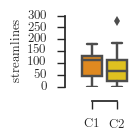

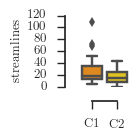

In [353]:
leftCing_results = connectome_differences(leftCing_matrices, 'Cing L', subject_list)
rightCing_results = connectome_differences(rightCing_matrices, 'Cing R', subject_list)

#### Creating a plot to show the connectivity results in a circular layout

Saving the results to show all connections of the cingulum and highlight the connections that are significantly different

In [144]:
leftCing_mean = np.mean(leftCing_matrices, axis=2)
leftCing_mean[leftCing_mean > 0] = 1
leftCing_mean[leftCing_results > 0] = 0

rightCing_mean = np.mean(rightCing_matrices, axis=2)
rightCing_mean[rightCing_mean > 0] = 2
rightCing_mean[rightCing_results > 0] = 0

leftCing_results[leftCing_results > 0] = 3
rightCing_results[rightCing_results > 0] = 4

mean_matrix = leftCing_mean + rightCing_mean + leftCing_results + rightCing_results
np.savetxt('../results/connectivity_matrix.txt', mean_matrix)

<matplotlib.colorbar.Colorbar instance at 0x7f2cc93c5518>

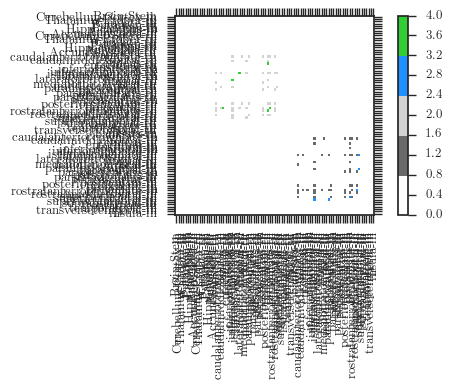

In [145]:
from matplotlib import colors

# make a color map of fixed colors
cmap = colors.ListedColormap(['w', 'dimgrey', 'lightgrey', 'dodgerblue', 'limegreen'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(mean_matrix, interpolation='none', cmap=cmap)
ax = plt.gca()
ax.set_xticks(np.arange(0,len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(np.arange(0,len(labels)))
ax.set_yticklabels(labels, rotation=0)
plt.colorbar()

In [52]:
def plot_connectivity_results(con, labels):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mne.viz import plot_connectivity_circle

    # Pre-calculated labels and positions for the DK atlas
    label_names = ['bankssts-lh', 'bankssts-rh', 'caudalanteriorcingulate-lh',
                   'caudalanteriorcingulate-rh', 'caudalmiddlefrontal-lh', 'caudalmiddlefrontal-rh', 
                   'cuneus-lh', 'cuneus-rh', 'entorhinal-lh',
                   'entorhinal-rh', 'frontalpole-lh', 'frontalpole-rh',
                   'fusiform-lh', 'fusiform-rh', 'inferiorparietal-lh',
                   'inferiorparietal-rh', 'inferiortemporal-lh', 'inferiortemporal-rh',
                   'insula-lh', 'insula-rh', 'isthmuscingulate-lh',
                   'isthmuscingulate-rh', 'lateraloccipital-lh', 'lateraloccipital-rh',
                   'lateralorbitofrontal-lh', 'lateralorbitofrontal-rh', 'lingual-lh',
                   'lingual-rh', 'medialorbitofrontal-lh', 'medialorbitofrontal-rh',
                   'middletemporal-lh', 'middletemporal-rh', 'paracentral-lh',
                   'paracentral-rh', 'parahippocampal-lh', 'parahippocampal-rh',
                   'parsopercularis-lh', 'parsopercularis-rh', 'parsorbitalis-lh',
                   'parsorbitalis-rh', 'parstriangularis-lh', 'parstriangularis-rh',
                   'pericalcarine-lh', 'pericalcarine-rh', 'postcentral-lh',
                   'postcentral-rh', 'posteriorcingulate-lh', 'posteriorcingulate-rh',
                   'precentral-lh', 'precentral-rh', 'precuneus-lh',
                   'precuneus-rh', 'rostralanteriorcingulate-lh', 'rostralanteriorcingulate-rh',
                   'rostralmiddlefrontal-lh', 'rostralmiddlefrontal-rh', 'superiorfrontal-lh',
                   'superiorfrontal-rh', 'superiorparietal-lh', 'superiorparietal-rh',
                   'superiortemporal-lh', 'superiortemporal-rh', 'supramarginal-lh',
                   'supramarginal-rh', 'temporalpole-lh', 'temporalpole-rh',
                   'transversetemporal-lh', 'transversetemporal-rh', 'Cerebellum-Cortex-lh',
                   'Thalamus-Proper-lh', 'Caudate-lh', 'Putamen-lh',
                   'Pallidum-lh', 'Hippocampus-lh', 'Amygdala-lh',
                   'Accumbens-area-lh', 'Brain-Stem', 'Cerebellum-Cortex-rh',
                   'Thalamus-Proper-rh', 'Caudate-rh', 'Putamen-rh',
                   'Pallidum-rh', 'Hippocampus-rh', 'Amygdala-rh',
                   'Accumbens-area-rh']

    node_angles = np.asarray([ 221.,  323.,  153.,  387.,  177.,  363.,  275.,  279.,  165.,
            375.,   97.,  443.,  213.,  331.,  249.,  295.,  197.,  347.,
            173.,  367.,  233.,  311.,  261.,  283.,  105.,  435.,  241.,
            303.,  121.,  419.,  193.,  351.,  237.,  307.,  189.,  355.,
            149.,  391.,  101.,  439.,  125.,  415.,  257.,  287.,  217.,
            327.,  209.,  335.,  201.,  343.,  245.,  299.,  129.,  411.,
            113.,  427.,  169.,  371.,  253.,  291.,  181.,  359.,  225.,
            319.,  137.,  403.,  205.,  339.,  229.,  157.,  117.,  133.,
            141.,  161.,  145.,  109.,  185.,  315.,  383.,  423.,  407.,
            399.,  379.,  395.,  431.])

    # Re-ordering the connectivity matrix to align with the ordered plot
    new_order = [np.where(np.asarray(labels) == item)[0][0] for item in label_names]
    con = con[new_order, :]
    con = con[:, new_order]

    # make a color map of fixed colors
    cmap = colors.ListedColormap(['w', 'dimgrey', 'lightgrey', 'dodgerblue', 'limegreen'])
    bounds=[0,1,2,3,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(5, 5), dpi=300)
    plot_connectivity_circle(con, 
                             label_names, 
                             node_angles=node_angles,
                             colormap = cmap,
                             vmin=0.5, vmax=1.5,
                             node_colors='k',
                             node_edgecolor='w',
                             facecolor='w',
                             textcolor='k',
                             fig=fig,
                             colorbar=False)
    plt.show()

In [ ]:
plot_connectivity_results(mean_matrix, labels)

## Checking association between edges and cognitive variables

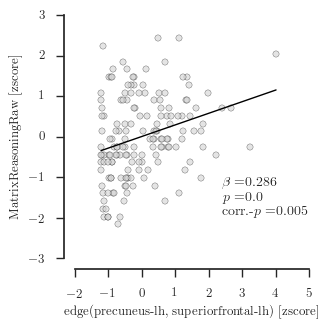

In [397]:
for region in ['Cing L', 'Cing R']:
    
    # Loading the behavioural data
    calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
    calm_grouped = calm_grouped.set_index('Unnamed: 0')
    calm_grouped = calm_grouped[calm_grouped['region'] == region]
    calm_behaviour = pd.read_csv('../data/raw_data/CALM_behavioural_data_Apr17.csv')
    calm_behaviour = calm_behaviour[calm_behaviour['ID No.'].isin(calm_behaviour['ID No.'].dropna())]
    calm_behaviour['MRI.ID'] = [get_imaging_ID(str(int(ID)), '../data/raw_data/MRI_ID_match_Aug17.csv') for ID in calm_behaviour['ID No.']]
    measures = ['Matrix_Reasoning_Raw', 'PPVT_Raw', 'AWMA_Digit_Recall_Raw', 'AWMA_Dot_Matrix_Raw', 'AWMA_Backward_Digit__Raw', 'AWMA_Mr_X__Raw', 'CMS_delayed_raw']
    calm_behaviour = calm_behaviour[np.hstack([['MRI.ID', 'Age_in_months'], measures])]
    calm_behaviour = calm_behaviour.dropna()
    calm_behaviour = calm_behaviour[calm_behaviour['MRI.ID'].isin(calm_grouped.index)]
    calm_behaviour = calm_behaviour.set_index('MRI.ID')

    # Z-scoring the behavioural data
    calm_behaviour[np.hstack(['Age_in_months', measures])] = zscore(calm_behaviour[np.hstack(['Age_in_months', measures])])

    # Making sure that the behavioural and imaging data contain the same participants
    calm_behaviour = pd.merge(calm_behaviour, calm_grouped, left_index=True, right_index=True)
    calm_behaviour = calm_behaviour[calm_behaviour.index.isin(subject_list)]
    available_subjects = np.squeeze(pd.DataFrame(subject_list)[pd.DataFrame(subject_list)[0].isin(calm_behaviour.index)].values).tolist()
    available_indices = [np.where(np.asarray(subject_list) == available_subject)[0][0] for available_subject in available_subjects]
    subject_list = np.asarray(subject_list)[available_indices]
    
    if region == 'Cing L':
        sign_edges = np.asarray(np.where(leftCing_results > 0))
    elif region == 'Cing R':
        sign_edges = np.asarray(np.where(rightCing_results > 0))
    
    # The matrix is symmetrical - duplicate entries are removed
    sign_edges = sign_edges[:, 0:int(.5*sign_edges.shape[1])]
    
    pvalues = np.ones(shape=[len(measures), sign_edges.shape[1]])
    for measure in np.arange(0, len(measures)):
        for i in np.arange(0, sign_edges.shape[1]):
            matrices = leftCing_matrices.copy()
            matrices = matrices[..., np.where(pd.DataFrame(subject_list).isin(subject_list).values == True)[0]]
            predictor = matrices[sign_edges[0][i], sign_edges[1][i], :]
            outcome = calm_behaviour[measures[measure]].values
            pvalues[measure, i] = ols('outcome ~ predictor', data=pd.DataFrame({'predictor':predictor, 'outcome':outcome})).fit().pvalues['predictor']

    # Applying Bonferroni correction for multiple comparisons
    _,_,_,alphaBonferroni = multipletests(pvalues.flatten(), method='bonferroni')
    sign_measures, related_edges = np.where(pvalues < alphaBonferroni)

    # Creating a scatter plot of the results
    for sign_measure in sign_measures:
        for related_edge in related_edges:
            sns.set_style("ticks")
            sns.set_style({'axes.grid': False,
                       'font.family': [u'serif'],
                       'font.sans-serif': [u'Computer Modern Unicode'],})

            predictor = zscore(matrices[sign_edges[0, related_edge], sign_edges[1, related_edge], :])
            outcome = calm_behaviour[measures[sign_measure]].values

            fig = plt.figure(figsize=(single_column, single_column), dpi=300, tight_layout=True)
            plt.scatter(predictor, outcome, facecolors='lightgrey', edgecolor='k', alpha=0.6)

            # Show the linear model fit
            df = pd.DataFrame({'predictor':predictor, 'outcome':outcome})
            linear_fit = ols('outcome ~ predictor', data=df).fit()
            newX = np.linspace(np.min(predictor), np.max(predictor), 100)
            plt.plot(newX, linear_fit.predict({'predictor':newX}), 'k', linewidth=1)
            sns.despine(offset=8, trim=True)
            ax = plt.gca()
            pvalue = linear_fit.pvalues['predictor']
            corrected_pvalue = multipletests(np.repeat(pvalue, len(measures)*sign_edges.shape[1]), method='bonferroni')[1][1]
            text = u'$\\beta=$' + str(round(linear_fit.params['predictor'], 3)) + \
            '\n$p=$' + str(round(pvalue, 3)) + \
            '\ncorr.-$p=$' + str(round(corrected_pvalue, 3))
            ax.text(np.max(df['predictor']) - 0.4*np.max(df['predictor']), np.min(df['outcome']) + 0.1*np.max(df['outcome']), text)
            ax.set_axis_bgcolor('white')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.tight_layout()

            # Adding the labels
            plt.ylabel(''.join(measures[sign_measures[sign_measure]].split('_')) + ' [zscore]')
            plt.xlabel('edge(' + labels[sign_edges[0, related_edge]] + ', ' + labels[sign_edges[1, related_edge]] + ') [zscore]')

            # Saving the figure
            filename = '_'.join([region, measures[sign_measure], labels[sign_edges[0, related_edge]], labels[sign_edges[1, related_edge]]])
            plt.savefig('../results/figures/' + filename + '.png', dpi=300)

## Visualizing the connectivity results

In [503]:
for tract in ['leftCing', 'rightCing']:
    import nibabel as nib
    img = nib.load('/imaging/jb07/CALM/BrainTypes/CALM/tractography_illustration/' + tract +'_mean_density.nii.gz')
    data = img.get_data()

    data = np.log10(data)
    data[isinf(data)] = 0
    nib.save(nib.Nifti1Image(data, img.affine), '/imaging/jb07/CALM/BrainTypes/CALM/tractography_illustration/' + tract + '_mean_density_log.nii.gz')

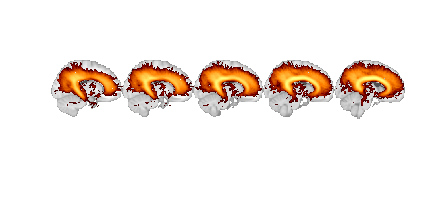

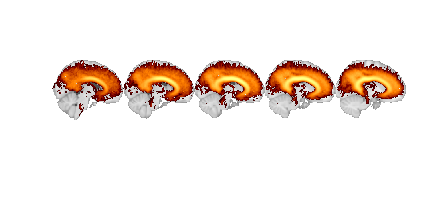

In [517]:
from nilearn import plotting

for tract in ['leftCing', 'rightCing']:
    stat_map = '/imaging/jb07/CALM/BrainTypes/CALM/tractography_illustration/' + tract + '_mean_density_log.nii.gz'
    fig = plt.figure(figsize=(double_column/2, 1.5), dpi=300)

    if tract == 'leftCing':
        cut_coords = [-14,-12,-10,-8,-6]
    elif tract == 'rightCing':
        cut_coords = [6,8,10,12,14]

    plotting.plot_stat_map(stat_map, 
                           threshold=0, 
                           annotate=False,
                           display_mode='x',
                           vmax=3,
                           colorbar=False,
                           cmap='afmhot',
                           cut_coords=cut_coords, 
                           figure=fig)
    plt.savefig('../results/figures/' + tract + '_density.png', dpi=300)

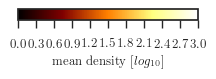

In [515]:
fig = plt.figure(figsize=(2, .75))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cmap = mpl.cm.afmhot
norm = mpl.colors.Normalize(vmin=0, vmax=3)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('mean density [$log_{10}$]')
plt.savefig('../results/figures/density_colourbar.png', dpi=300)

## Reliability

In [200]:
from subprocess import call
from scipy.stats import sem

In [204]:
mengya_folder = '/imaging/jb07/CALM/BrainTypes/CALM/Mengya/'
joe_folder =  '/imaging/jb07/CALM/BrainTypes/CALM/tractography/'
subject_list = sorted([subject for subject in os.listdir(mengya_folder) if re.search('CBU', subject)])
results = []

for subject in subject_list:
    infile_1 = mengya_folder + subject + '/rightCing_density.nii'
    infile_2 = joe_folder + subject + '/rightCing_density.nii'
    
    cmd = 'fslcc ' + infile_1 + ' ' + infile_2 + ' > ' + mengya_folder + '/' + subject + '/corr.txt'
    call(cmd, shell=True)
    
    results.append(np.loadtxt(mengya_folder + '/' + subject + '/corr.txt')[-1])

In [205]:
print('mean=%.2f, SE=%.3f, range=%.2f-%.3f' % (np.mean(results), sem(results), np.min(results), np.max(results)))

mean=0.95, SE=0.005, range=0.87-0.990
